# Homework 3

## 1. Implement L1 norm regularization as a custom loss function


In [4]:
import torch

def lasso_reg(params, l1_lambda):

  l1_penalty = torch.nn.L1Loss(size_average=False)
  reg_loss = 0

  for param in params:
    reg_loss += l1_penalty(param)

  loss += l1_lambda * reg_loss
  return loss

## 2. The third-to-last paragraph in the notebook is concerning early stopping, an "old" regularization technique which involves the stopping of training earlier than the number of epochs would suggest. Read the paragraph and download the paper from Prechelt et al. 

###  a. Implement early stopping in the $E_{opt}$ specification

In the paper, the value $E_{opt}$ is defned to be the lowest validation set error obtained in epochs up to $t$: $$E_{opt}(t) = \min_{t \le t'} E_{va}(t')$$ where $E_{va}$ is the validation error, i.e. the corresponding error on the validation set. As per instructions, I'm going to use the test data as validation.

In [102]:
# import in Colab

import sys
sys.path.append('/content/mnist.py')
sys.path.append('/content/train_utils.py')

import mnist
from train_utils import accuracy, AverageMeter

from torch import nn

In [103]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.h1 = nn.Linear(28*28, 16)
        self.h2 = nn.Linear(16, 32)
        self.h3 = nn.Linear(32, 24)
        self.out = nn.Linear(24, 10)
    
    def forward(self, X, activ_hidden=nn.functional.relu):
        out = self.flat(X)
        out = activ_hidden(self.h1(out))
        out = activ_hidden(self.h2(out))
        out = activ_hidden(self.h3(out))
        out = self.out(out)
        return out

In [137]:
def train_epoch(model, dataloader, loss_fn, optimizer, loss_meter, performance_meter, performance): 
    for X, y in dataloader:
        optimizer.zero_grad() 
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()
        acc = performance(y_hat, y)
        loss_meter.update(val=loss.item(), n=X.shape[0])
        performance_meter.update(val=acc, n=X.shape[0])


def train_model(model, dataloader1, dataloader2, loss_fn, optimizer, num_epochs, performance=accuracy): 
    model.train()

    E = {
        "epoch": [],"training perf": [], "validation perf": [], "parameters": [], "optimizer": []
    }

    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        performance_meter = AverageMeter()

        train_epoch(model, dataloader1, loss_fn, optimizer, loss_meter, performance_meter, performance)
 
        fin_loss, fin_perf = test_model(model, dataloader2, loss_fn=loss_fn)

        E["epoch"].append(epoch)
        E["training perf"].append(performance_meter)
        E["validation perf"].append(fin_perf)
        E["parameters"].append(model.state_dict())
        E["optimizer"].append(optimizer.state_dict())

    return loss_meter.sum, performance_meter.avg, E


def test_model(model, dataloader, performance=accuracy, loss_fn=None):
    # create an AverageMeter for the loss if passed
    if loss_fn is not None:
        loss_meter = AverageMeter()
    
    performance_meter = AverageMeter()

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            y_hat = model(X)
            loss = loss_fn(y_hat, y) if loss_fn is not None else None
            acc = performance(y_hat, y)
            if loss_fn is not None:
                loss_meter.update(loss.item(), X.shape[0])
            performance_meter.update(acc, X.shape[0])

    # get final performances
    fin_loss = loss_meter.sum if loss_fn is not None else None
    fin_perf = performance_meter.avg
    return fin_loss, fin_perf

In [138]:
minibatch_size_train = 256
minibatch_size_test = 512

trainloader, testloader, trainset, testset = mnist.get_data(batch_size_train=minibatch_size_test, batch_size_test=minibatch_size_test)

learn_rate = 0.1
num_epochs = 30

model = MLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

train_loss, train_acc, E = train_model(model, trainloader, testloader, loss_fn, optimizer, num_epochs)

Since `Validation_error = 1 - Validation_performance`, minimizing the error is equivalent to maximizing the performance.

The best validation performance is 0.9701166666666666, obtained at epoch no. 29 out of 30.


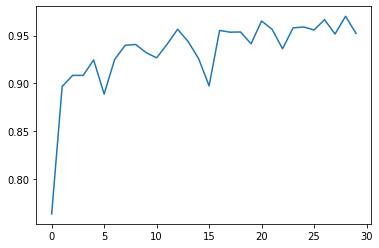

In [148]:
from matplotlib import pyplot as plt

val_list = list(E["validation perf"])
maxval = max(E["validation perf"])
index = val_list.index(max(val_list)) + 1 

plt.plot(E["epoch"], E["validation perf"] )
print(f"The best validation performance is {maxval}, obtained at epoch no. {index} out of {num_epochs}.")

###  b$^*$. Implement early stopping in one of the additional specifications

A stopping criterion described in the paper is based on the *generalization loss*: $$ GL (t) = 100 * \big( \frac{E_{va}(t)}{E_{opt}(t)} -1 \big)$$ that is, the validation error over the minimum so far in percent. We should stop as soon as this value exceeds a certain threshold $\alpha$.

As reported in the paper, this criterion is used to maximize the probability to find a good solution, as opposed to maximizing the average quality of the solutions.

In [154]:
alpha = 1
E_opt = 1 - val_list[0]

for i in range(num_epochs):
  E_va = 1 - val_list[i]

  if E_va < E_opt:
    E_opt = E_va

  GL = 100 * (E_va/E_opt - 1)

  if GL > alpha:
    print(f"This stopping criterion halts the computation at epoch {i+1}")
    break

This stopping criterion halts the computation at epoch 6


As we can see, this criterion stops very early, at the first epoch with lower performance. A solution is to add momentum to SGD to minimize oscillations:

In [164]:
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9)
num_epochs = 15

train_loss_m, train_acc_m, E_m = train_model(model, trainloader, testloader, loss_fn, optimizer, num_epochs)

The best validation performance is 0.9777, obtained at epoch no. 14 out of 15.


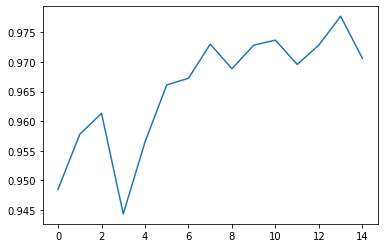

In [165]:
from matplotlib import pyplot as plt

val_list = list(E_m["validation perf"])
maxval = max(E_m["validation perf"])
index = val_list.index(max(val_list)) + 1 

plt.plot(E_m["epoch"], E_m["validation perf"] )
print(f"The best validation performance is {maxval}, obtained at epoch no. {index} out of {num_epochs}.")

In [170]:
alpha = 2
E_opt = 1 - val_list[0]

for i in range(num_epochs):
  E_va = 1 - val_list[i]

  if E_va < E_opt:
    E_opt = E_va

  GL = 100 * (E_va/E_opt - 1)
  
  if GL > alpha:
    print(f"This stopping criterion halts the computation at epoch {i+1}")
    break

This stopping criterion halts the computation at epoch 4


From the plot we can see that SGD with momentum performs a lot better than without, reducing oscillations. Nevertheless, this criterion stops very early anyways. 